# **Replacing colors with their codes**

Replacing colors with their codes (apply palette) on the GPU. Input data: an image in RGB24 format, where the number of colors is known to not exceed a threshold of 256 values. First, on the CPU, you need to determine what colors there are and create a palette. Then, after debugging the basic implementation, you should expand it as follows: <br>
a. Compare with and without constant memory.<br>
b. Transfer the palette formation stage to the video card.

# **Замена цветов на их коды</p>**

Замена цветов на их коды (применить палитру) на GPU. Входные данные: изображение в формате RGB24, где заведомо количество цветов не превышает порога в 256 значений. Предварительно на ЦП нужно определить, какие есть цвета, составить палитру.
Затем, после отладки базовой реализации, следует дополнить её следующим образом: <br>
a.	Сравнить с использованием константной памяти и без неё.<br>
b.	Перенести этап формирования палитры на видеокарту.

In [ ]:
import numpy as np
import time
from numba import cuda, njit,jit
from PIL import Image

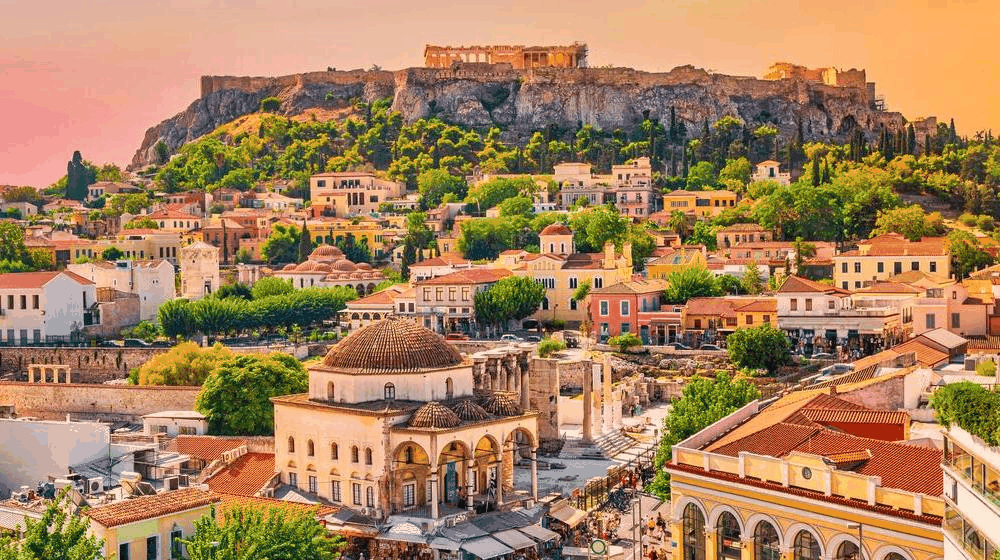

In [ ]:
image = Image.open("athens.jpg")

out = image.convert('P', palette=Image.ADAPTIVE, colors=256).convert('RGB')
out

In [ ]:
#Конвертируем в array
arr = np.array(out)
arr.shape

(560, 1000, 3)

In [ ]:
#Список цветов
colors = np.unique(arr.reshape(-1,3),axis=0)
len(colors)

256

In [ ]:
colors.shape

(256, 3)

In [ ]:
# GPU
@cuda.jit
def rgb_to_code(image,out,colors):
    colors = enumerate(colors)
    i, j = cuda.grid(2)
    if i < image.shape[0] and j < image.shape[1]:
        for code,rgb_code in colors:
          R = image[i, j, 0]
          G = image[i, j, 1]
          B = image[i, j, 2]
          if (rgb_code[0] == R and rgb_code[1] == G and rgb_code[2] == B):
              out[i, j] = code
              break

In [ ]:
#Загружаем данные на gpu
d_image = cuda.to_device(arr)
d_out = cuda.to_device(np.zeros(shape=arr.shape[:2], dtype=np.int32))

#Определяем размер блока и кол-во блоков
block_size = 32
grid_size = 32

#Считаем на gpu
t1 = time.time()
rgb_to_code[(grid_size,grid_size),(block_size,block_size)](d_image,d_out,colors)
result = d_out.copy_to_host()
t2 = time.time()
print('Время выполнения: ' + str(t2-t1) + ' с')

Время выполнения: 0.16011810302734375 с


/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
result.shape

(560, 1000)

In [ ]:
def code_to_rgb(result,colors):
    x,y = result.shape
    color_image = np.zeros((x,y,3))
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            color_image[i,j]=colors[result[i,j]]
    return color_image

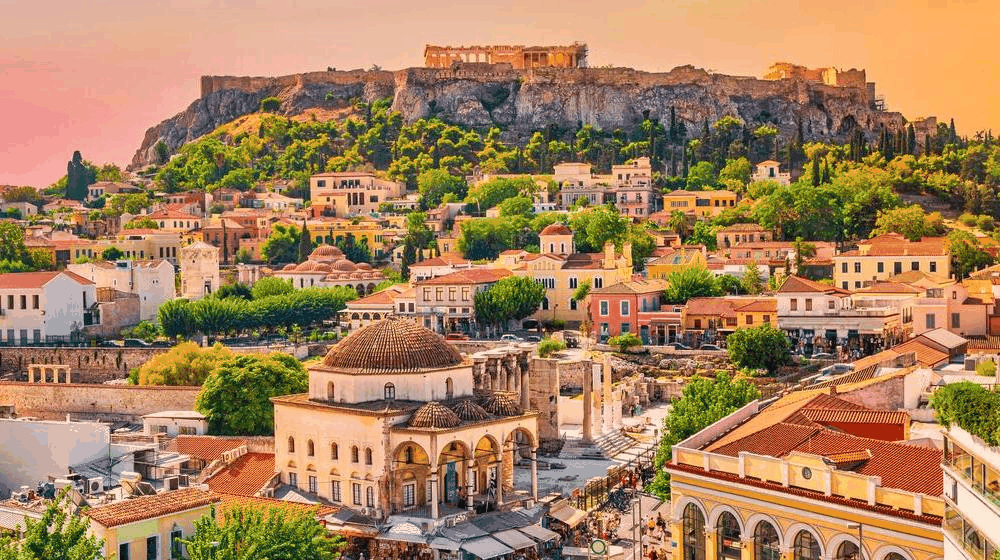

In [ ]:
# Определяем размер блока и кол-во блоков
block_size = 32
grid_size = 32

color_image = code_to_rgb(result,colors)
im_out = Image.fromarray(np.uint8(color_image))
im_out

In [ ]:
# CPU
@njit()
def rgb_to_code_cpu(image, out, colors):
    colors = list(enumerate(colors))
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for code,rgb_code in colors:
              R = image[i, j, 0]
              G = image[i, j, 1]
              B = image[i, j, 2]
              if (rgb_code[0] == image[i, j, 0] and rgb_code[1] == image[i, j, 1] and rgb_code[2] == image[i, j, 2]):
                  out[i, j] = code
    return out

In [ ]:
@njit()
def code_to_rgb_cpu(result, colors):
    x, y = result.shape
    color_image = np.zeros((x, y, 3))
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            color_image[i, j] = colors[result[i, j]]
    return color_image

In [ ]:
out = np.zeros(shape=arr.shape[:2], dtype=np.int32)

#Считаем на cpu
t1 = time.time()
result = rgb_to_code_cpu(arr,out,colors)
t2 = time.time()
print('Время выполнения: ' + str(t2-t1) + ' с')

Время выполнения: 2.980670928955078 с


In [ ]:
result.shape

(560, 1000)

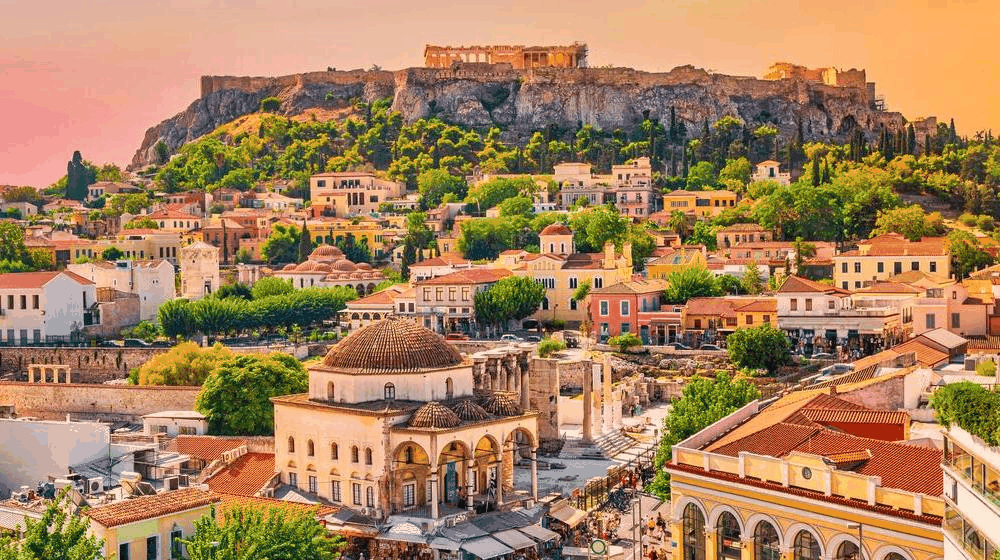

In [ ]:
color_image = code_to_rgb_cpu(result,colors)
im_out = Image.fromarray(np.uint8(color_image))
im_out

In [ ]:
# Память на хосте
out = np.zeros(shape=arr.shape[:2], dtype=np.int32)

#Определяем размер блока и кол-во блоков
block_size = 32
grid_size = 32

#Считаем на gpu
t1 = time.time()
rgb_to_code[(grid_size,grid_size),(block_size,block_size)](arr,out,colors)
#result = d_out.copy_to_host()
t2 = time.time()
print('Время выполнения: ' + str(t2-t1) + ' с')

Время выполнения: 0.009158611297607422 с


/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:886: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
#Делаем 3d палитру
@cuda.jit
def make_3dpallete(image, pallete):
    s_i, s_j = cuda.grid(2)
    stride_i,stride_j=cuda.gridsize(2)

    #Перебираем все пиксели параллельно
    for i in range(s_i, image.shape[0],stride_i):
        for j in range(s_j, image.shape[1],stride_j):
            cuda.atomic.add(pallete, (image[i,j,0],image[i,j,1],image[i,j,2]), 1)

#Номеруем все цвета
@njit
def make_codes(pallete):
    c = 0
    for i in range(256):
        for j in range(256):
            for k in range(256):
                if pallete[i,j,k] != 0:
                    pallete[i,j,k] = c
                    c+=1

#Заменяем rgb на коды
@cuda.jit
def rgb_to_codes(image,pallete,out):
    i, j = cuda.grid(2)
    if i < image.shape[0] and j < image.shape[1]:
        x,y,z = image[i,j]
        out[i,j] = pallete[x,y,z]

In [ ]:
#Определяем размер блока и кол-во блоков
block_size = 32
grid_size = 32

#Загружаем данные на gpu
d_image = cuda.to_device(arr)
d_pallete = cuda.to_device(np.zeros(shape=(256,256,256), dtype=np.int32))

#Делаем палитру
t1 = time.time()
make_3dpallete[(grid_size,grid_size),(block_size,block_size)](d_image,d_pallete)
pallete = d_pallete.copy_to_host()
make_codes(pallete)

#Загружаем данные на gpu (Обновляем палитру + загружаем out)
d_pallete = cuda.to_device(pallete)
d_out = cuda.to_device(np.zeros(shape=arr.shape[:2], dtype=np.int32))

#Заменяем цвета на коды
rgb_to_codes[(grid_size,grid_size),(block_size,block_size)](d_image,d_pallete,d_out)
result = d_out.copy_to_host()
t2 = time.time()
print('Время выполнения: ' + str(t2-t1) + ' с')

Время выполнения: 0.7324731349945068 с


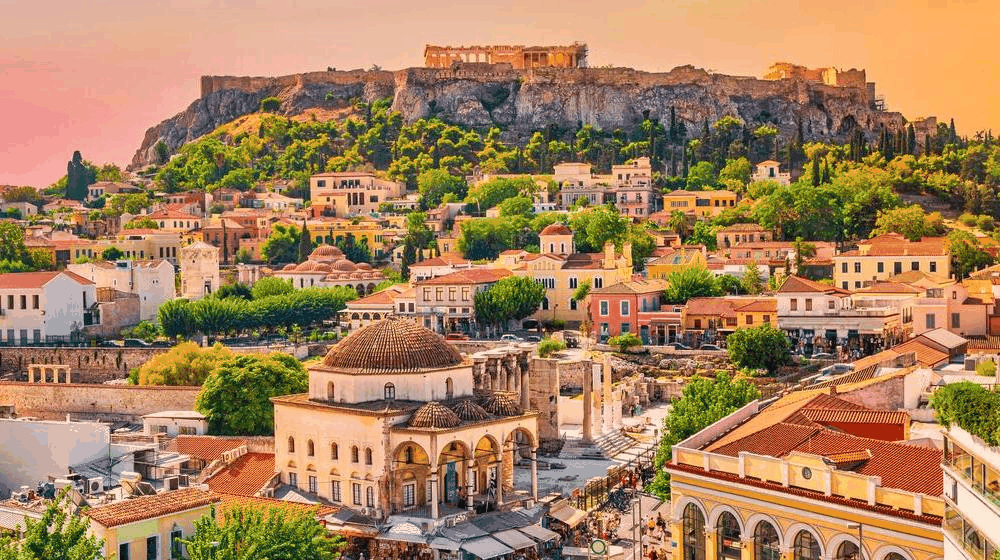

In [ ]:
#Проверка
x,y = result.shape
color_image = np.zeros((x,y,3))
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        color_image[i,j]=colors[result[i,j]]

im_out = Image.fromarray(np.uint8(color_image))
im_out

In [ ]:
# Загружаем данные на GPU
d_image = cuda.to_device(arr)
d_out_constant = cuda.to_device(np.zeros(shape=arr.shape[:2], dtype=np.int32))

# Определяем размер блока и кол-во блоков
block_size = 32
grid_size = 32

# Передаем цвета палитры в константную память
colors_const = cuda.to_device(colors)

@cuda.jit
def rgb_to_code_constant(image, out, colors_const):
    i, j = cuda.grid(2)
    if i < image.shape[0] and j < image.shape[1]:
        R = image[i, j, 0]
        G = image[i, j, 1]
        B = image[i, j, 2]

        # Читаем цвета из константной памяти
        for code in range(colors_const.shape[0]):
            if (colors_const[code, 0] == R and colors_const[code, 1] == G and colors_const[code, 2] == B):
                out[i, j] = code
                break

# Считаем на GPU с использованием константной памяти
t1 = time.time()
rgb_to_code_constant[(grid_size, grid_size), (block_size, block_size)](d_image, d_out_constant, colors_const)
result_constant = d_out_constant.copy_to_host()
t2 = time.time()
print('Время выполнения (с использованием константной памяти):', str(t2 - t1), 'с')


Время выполнения (с использованием константной памяти): 0.15819621086120605 с


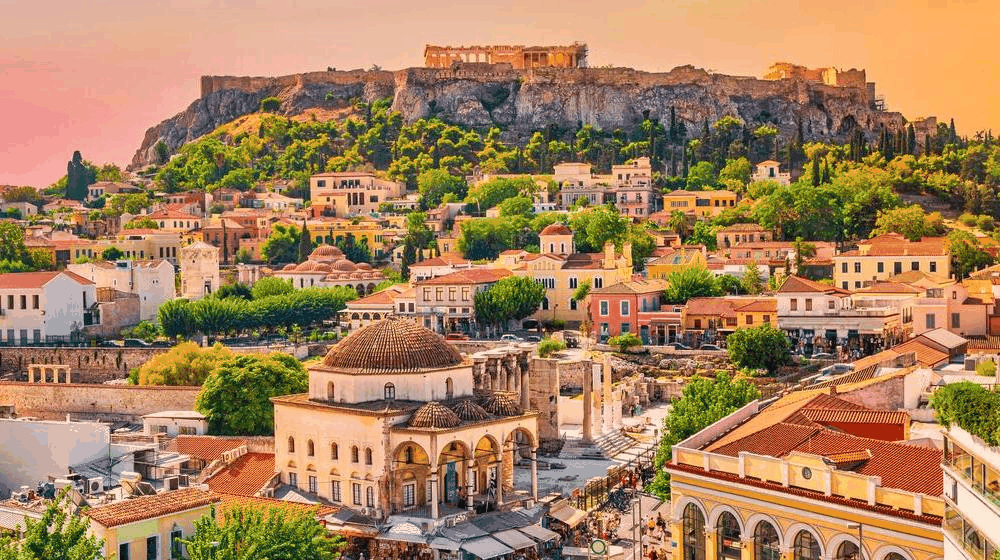

In [ ]:
#Проверка
x,y = result_constant.shape
color_image = np.zeros((x,y,3))
for i in range(result_constant.shape[0]):
    for j in range(result_constant.shape[1]):
        color_image[i,j]=colors[result[i,j]]

im_out = Image.fromarray(np.uint8(color_image))
im_out